<a href="https://colab.research.google.com/github/PiKaChu-wcg/pytorch/blob/main/mnits_con.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.utils.data as data

In [40]:
image_size=28
num_classes=10
num_epoch=20
batch_size=64
train_dataset=dsets.MNIST(root='./data',
            train=True,
            transform=transforms.ToTensor(),
            download=True)
test_dataset=dsets.MNIST(root='./data',train=False,transform=transforms.ToTensor())
train_loader=data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)

In [14]:
indices=range(len(test_dataset))
indices_val=indices[:5000]
indices_test=indices[5000:]
sampler_val=data.sampler.SubsetRandomSampler(indices_val)
sampler_test=data.sampler.SubsetRandomSampler(indices_test)
validation_loader=data.DataLoader(dataset=test_dataset,batch_size=batch_size,sampler=sampler_val)
test_loader=data.DataLoader(dataset=test_dataset,batch_size=batch_size,sampler=sampler_test)

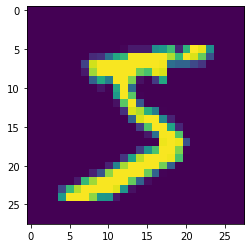

In [20]:
plt.imshow(train_dataset[0][0].numpy()[0,...])

In [56]:
depth=[4,8]
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        self.conv1=nn.Conv2d(1,4,5,padding=2)
        self.pool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(depth[0],depth[1],5,padding=2)
        self.fc1=nn.Linear(image_size//4*image_size//4*depth[1],512)
        self.fc2=nn.Linear(512,num_classes)
    def forward(self,x):
        x=F.relu(self.conv1(x))
        x=self.pool(x)
        x=F.relu(self.conv2(x))
        x=self.pool(x)
        x=x.view(-1,image_size//4*image_size//4*depth[1])
        x=F.relu(self.fc1(x))
        x=F.dropout(x,training=self.training)
        x=self.fc2(x)
        x=F.log_softmax(x,dim=0)
        return x
    def retrieve_features(self,x):
        feature_map1=F.relu(self.conv1(x))
        x=self.pool(feature_map1)
        feature_map2=F.relu(self.conv2(x))
        return (feature_map1,feature_map2)


In [28]:
def rightness(predictions, labels):
    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，batch_size行num_classes列的矩阵，labels是数据之中的正确答案"""
    pred = torch.max(predictions.data, 1)[1] # 对于任意一行（一个样本）的输出值的第1个维度，求最大，得到每一行的最大元素的下标
    rights = pred.eq(labels.data.view_as(pred)).sum() #将下标与labels中包含的类别进行比较，并累计得到比较正确的数量
    return rights, len(labels) #返回正确的数量和这一次一共比较了多少元素

In [49]:
net=ConvNet()
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.9)
record=[]
weights=[]
for epoch in range(num_epoch):
    train_rights=[]
    for batch_idx,(data,target) in enumerate(train_loader):    
        data,target=data.clone().requires_grad_(True),target.clone().detach()
        net.train()
        output=net(data)
        loss=criterion(output,target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        right=rightness(output,target)
        train_rights.append(right)
        if batch_idx%100==0:
            net.eval()
            val_rights=[]
            for (data,target) in validation_loader:
                data, target = data.clone().requires_grad_(True), target.clone().detach()
                output=net(data)
                right=rightness(output,target)
                val_rights.append(right)
            train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
            val_r = (sum([tup[0] for tup in val_rights]), sum([tup[1] for tup in val_rights]))
            print(val_r)
            print('训练周期: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t训练正确率: {:.2f}%\t校验正确率: {:.2f}%'.format(
                epoch, batch_idx * batch_size, len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.data, 
                100. * train_r[0].numpy() / train_r[1], 
                100. * val_r[0] / val_r[1]))
            record.append((100 - 100. * train_r[0] / train_r[1], 100 - 100. * val_r[0] / val_r[1]))
            weights.append([net.conv1.weight.data.clone(), net.conv1.bias.data.clone(), 
                            net.conv2.weight.data.clone(), net.conv2.bias.data.clone()])


(tensor(821), 5000)
训练周期: 0 [0/60000 (0%)]	Loss: 2.300646	训练正确率: 10.94%	校验正确率: 16.42%
(tensor(2077), 5000)
训练周期: 0 [6400/60000 (11%)]	Loss: 2.285316	训练正确率: 16.72%	校验正确率: 41.54%
(tensor(2748), 5000)
训练周期: 0 [12800/60000 (21%)]	Loss: 2.221250	训练正确率: 23.49%	校验正确率: 54.96%
(tensor(3071), 5000)
训练周期: 0 [19200/60000 (32%)]	Loss: 2.032632	训练正确率: 29.44%	校验正确率: 61.42%
(tensor(3546), 5000)
训练周期: 0 [25600/60000 (43%)]	Loss: 1.165784	训练正确率: 35.26%	校验正确率: 70.92%
(tensor(3837), 5000)
训练周期: 0 [32000/60000 (53%)]	Loss: 0.841432	训练正确率: 41.84%	校验正确率: 76.74%
(tensor(4054), 5000)
训练周期: 0 [38400/60000 (64%)]	Loss: 0.697914	训练正确率: 47.30%	校验正确率: 81.08%
(tensor(4138), 5000)
训练周期: 0 [44800/60000 (75%)]	Loss: 0.597752	训练正确率: 51.80%	校验正确率: 82.76%
(tensor(4169), 5000)
训练周期: 0 [51200/60000 (85%)]	Loss: 0.536815	训练正确率: 55.49%	校验正确率: 83.38%
(tensor(4260), 5000)
训练周期: 0 [57600/60000 (96%)]	Loss: 0.511497	训练正确率: 58.50%	校验正确率: 85.20%
(tensor(4304), 5000)
训练周期: 1 [0/60000 (0%)]	Loss: 0.506356	训练正确率: 85.94%	校验正确率: 86.08%


Text(0, 0.5, 'Error rate')

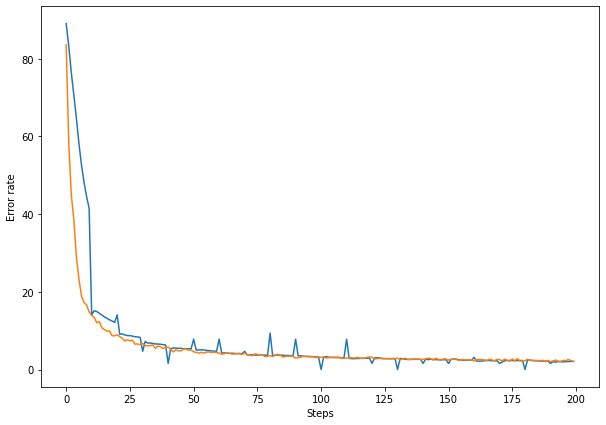

In [50]:
plt.figure(figsize = (10, 7))
plt.plot(record) #record记载了每一个打印周期记录的训练和校验数据集上的准确度
plt.xlabel('Steps')
plt.ylabel('Error rate')

In [51]:
net.eval()
vals=[]
for data, target in test_loader:
    data, target = data.clone().detach().requires_grad_(True), target.clone().detach()
    output = net(data) #将特征数据喂入网络，得到分类的输出
    val = rightness(output, target) #获得正确样本数以及总样本数
    vals.append(val) #记录结果

#计算准确率
rights = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 100. * rights[0].numpy() / rights[1]
print(right_rate)   

99.02


标签是： 9


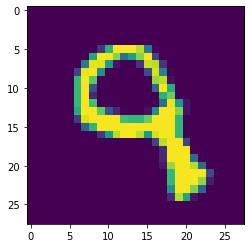

In [52]:
idx = 4000
muteimg = test_dataset[idx][0].numpy()
plt.imshow(muteimg[0,...])
print('标签是：',test_dataset[idx][1])

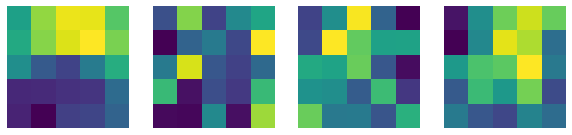

In [53]:
plt.figure(figsize = (10, 7))
for i in range(4):
    plt.subplot(1,4,i + 1)
    plt.axis('off')
    plt.imshow(net.conv1.weight.data.numpy()[i,0,...]) 

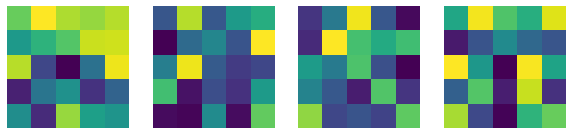

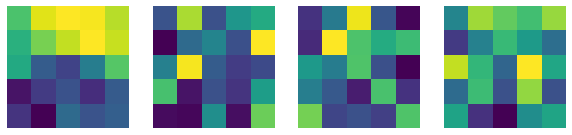

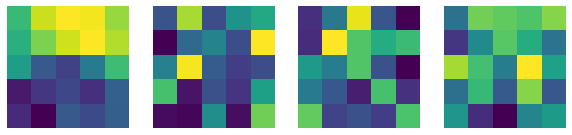

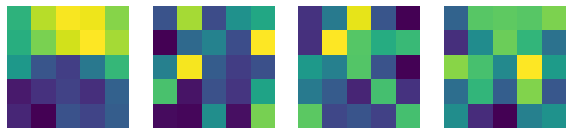

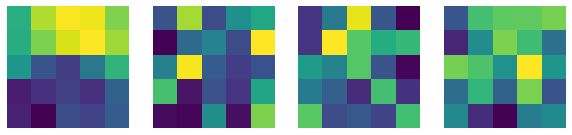

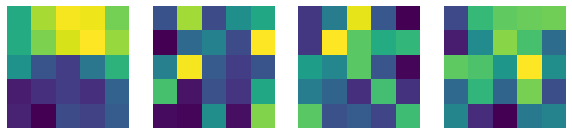

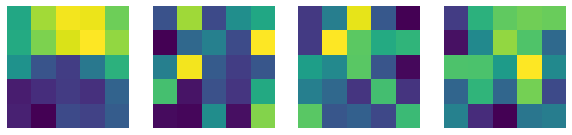

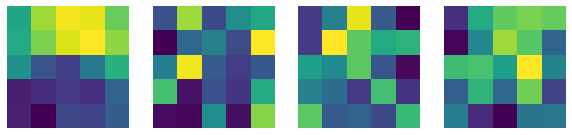

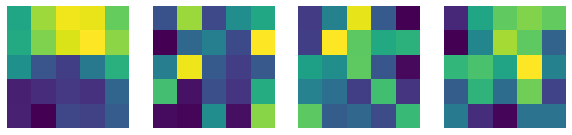

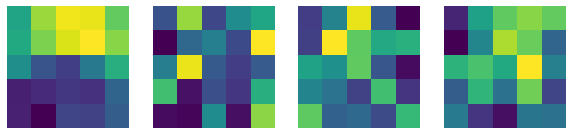

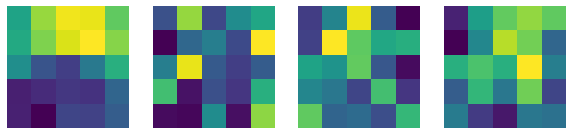

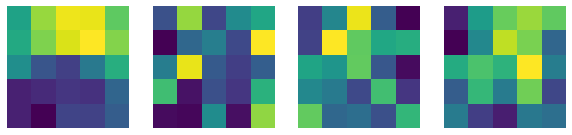

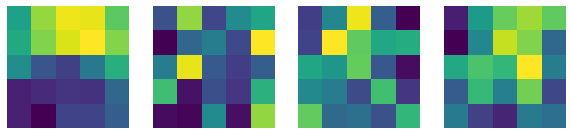

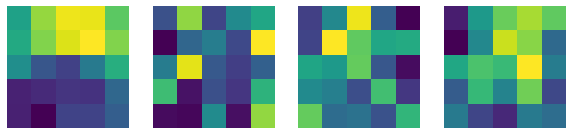

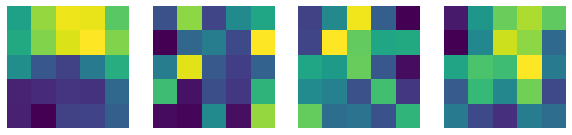

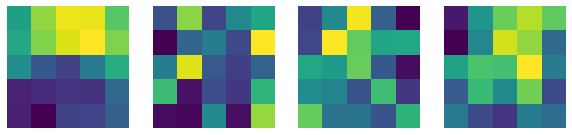

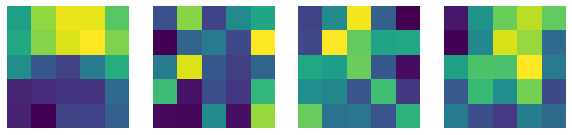

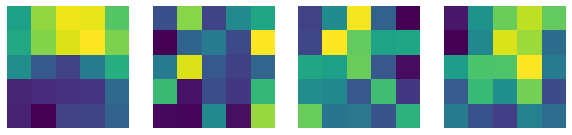

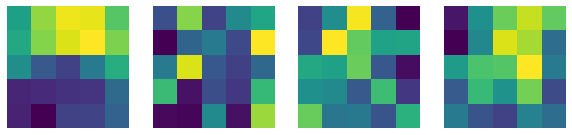

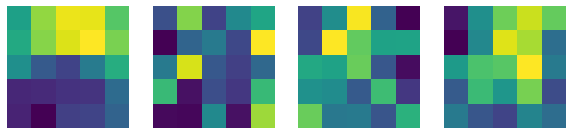

In [54]:
i = 0
for tup in weights:
    if i % 10 == 0 :
        layer1 = tup[0]
        fig = plt.figure(figsize = (10, 7))
        for j in range(4):
            plt.subplot(1, 4, j + 1)
            plt.axis('off')
            plt.imshow(layer1.numpy()[j,0,...])
    i += 1

In [ ]:
input_x = test_dataset[idx][0].unsqueeze(0) 
feature_maps = net.retrieve_features(input_x) #feature_maps是有两个元素的列表，分别表示第一层和第二层卷积的所有特征图

plt.figure(figsize = (10, 7))

#有四个特征图，循环把它们打印出来
for i in range(4):
    plt.subplot(1,4,i + 1)
    plt.axis('off')
    plt.imshow(feature_maps[0][0, i,...].data.numpy())

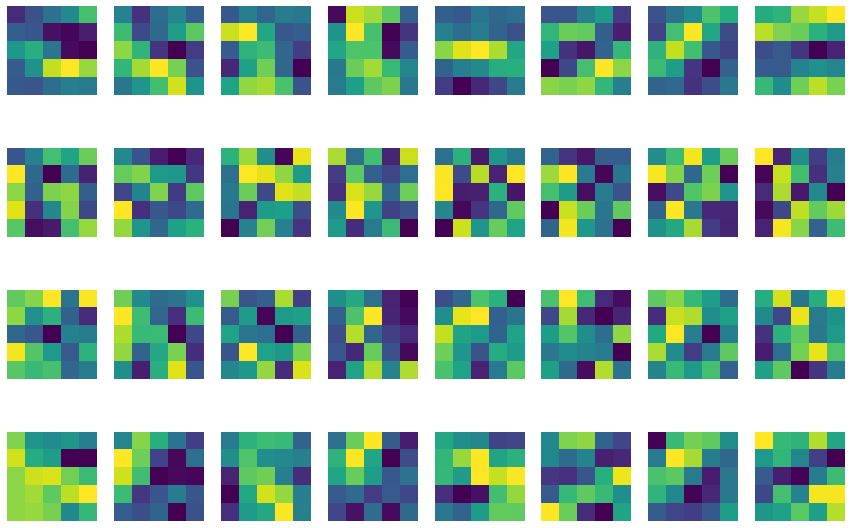

In [57]:
plt.figure(figsize = (15, 10))
for i in range(4):
    for j in range(8):
        plt.subplot(4, 8, i * 8 + j + 1)
        plt.axis('off')
        plt.imshow(net.conv2.weight.data.numpy()[j, i,...])